In [118]:
import scipy.special as sps
import pyro 
import pyro.distributions as dist
import torch
from torch.distributions import constraints
from pyro.infer import MCMC, NUTS
from scipy.stats import norm
from torch import nn
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.nn import PyroModule
from pyro import optim
from pyro.infer import SVI, Trace_ELBO
from pyro.nn import PyroSample
from pyro.infer import Predictive


pyro.enable_validation(True)
pyro.set_rng_seed(1)
pyro.enable_validation(True)

import sys 
sys.path.append('../../python/')

import os

import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import statsmodels.api as sm
import statsmodels

import HNSCC_analysis_pipeline_lib as lib

import pickle as pkl
import seaborn as sbn

print(pyro.__version__)
assert pyro.__version__.startswith('1.1.0')

import time

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from scipy.stats import norm, gamma, poisson, beta 

%matplotlib inline

1.1.0


# Hill-Langmuir Bayesian Regression 

# Bayesian Hill Model Regression 

The Hill model is defined as: 

$$ F(c, E_{max}, E_0, EC_{50}, H) = E_0 + \frac{E_{max} - E_0}{1 + (\frac{EC_{50}}{C})^H} $$

Where concentration, $c$ is in uM, and is *not* in logspace. 

To quantify uncertainty in downstream modeling, and to allow placement of priors on the relevant variables, we will do this in a bayesian framework. 

# Building Intuition with the Hill Equation

![](https://media.springernature.com/lw685/springer-static/image/art%3A10.1038%2Fsrep14701/MediaObjects/41598_2015_Article_BFsrep14701_Fig1_HTML.jpg?as=webp)

1. Di Veroli GY, Fornari C, Goldlust I, Mills G, Koh SB, Bramhall JL, et al. An automated fitting procedure and software for dose-response curves with multiphasic features. Scientific Reports. 2015 Oct 1;5(1):1–11. 


In [223]:
# https://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html
def f(E0=2.5, Emax=0, log_EC50=-2, H=1):
    
    EC50 = 10**log_EC50
    plt.figure(2, figsize=(10,5))
    xx = np.logspace(-4, 1, 100)
    yy = E0 + (Emax - E0)/(1+(EC50/xx)**H)
    
    plt.plot(np.log10(xx),yy, 'r-')
    plt.ylim(-0.2, 3)
    plt.xlabel('log10 [Concentration (uM)] ')
    plt.ylabel('cell response')
    plt.show()

interactive_plot = interactive(f, E0=(1,3,0.5), Emax=(0.,1.,0.05), log_EC50=(-5,2,0.1), H=(1,5,1))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=2.5, description='E0', max=3.0, min=1.0, step=0.5), FloatSlider(value=…

# Define Model + Guide 

In [303]:
class plotter: 
    def __init__(self, params, figsize=(20,10), subplots = (2,7)): 
        '''
        '''
        assert len(params) <= subplots[0]*subplots[1], 'wrong number of subplots for given params to report'
        self.fig, self.axes = plt.subplots(*subplots,figsize=figsize, sharex='col', sharey='row')
        self.vals = {p:[] for p in params}
        self.params = params
        
    def record(self):
        '''
        '''
        for p in self.params: 
            self.vals[p].append(pyro.param(p).item())
    
    def plot_all(self): 
        '''
        '''
        for p, ax in zip(self.params, self.axes.flat): 
            ax.plot(self.vals[p], 'b-')
            ax.set_title(p, fontsize=25)
            ax.set_xlabel('step', fontsize=20)
            ax.set_ylabel('param value', fontsize=20)
            
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.35)
        plt.show()
        
def model(X, Y=None):
    '''
    
    '''
    E0 = pyro.sample('E0', dist.Normal(1., E0_std))

    Emax = pyro.sample('Emax', dist.Beta(a_emax, b_emax))
    
    H = pyro.sample('H', dist.Gamma(alpha_H, beta_H))
    
    EC50 = 10**pyro.sample('log_EC50', dist.Normal(mu_ec50, std_ec50))

    obs_sigma = pyro.sample("obs_sigma", dist.Gamma(a_obs, b_obs))
    
    obs_mean = E0 + (Emax - E0)/(1+(EC50/X)**H)

    with pyro.plate("data", X.shape[0]):
        obs = pyro.sample("obs", dist.Normal(obs_mean.squeeze(-1), obs_sigma), obs=Y)
        
    return obs_mean

def guide(X, Y=None):
    
    _E0_mean = pyro.param('E0_mean', torch.tensor(0.))
    _E0_std = pyro.param('E0_std', torch.tensor(E0_std), constraint=constraints.positive)
    E0 = pyro.sample('E0', dist.Normal(_E0_mean, _E0_std))
    
    _a_emax = pyro.param('_a_emax', torch.tensor(a_emax), constraint=constraints.positive)
    _b_emax = pyro.param('_b_emax', torch.tensor(b_emax), constraint=constraints.positive)
    Emax = pyro.sample('Emax', dist.Beta(_a_emax, _b_emax))
    
    _alpha_H = pyro.param('_alpha_H', torch.tensor(alpha_H), constraint=constraints.positive)
    _beta_H = pyro.param('_beta_H', torch.tensor(beta_H), constraint=constraints.positive)
    H = pyro.sample('H', dist.Gamma(_alpha_H, _beta_H))

    _mu_ec50 = pyro.param('_mu_ec50', torch.tensor(mu_ec50))
    _std_ec50 = pyro.param('_std_ec50', torch.tensor(std_ec50), constraint=constraints.positive)
    EC50 = pyro.sample('log_EC50', dist.Normal(_mu_ec50, _std_ec50))
    
    _a_obs = pyro.param('_a_obs', torch.tensor(a_obs), constraint=constraints.positive)
    _b_obs = pyro.param('_b_obs', torch.tensor(b_obs), constraint=constraints.positive)
    obs_sigma = pyro.sample("obs_sigma", dist.Gamma(_a_obs, _b_obs))
    
    obs_mean = E0 + (Emax - E0)/(1+(EC50/X)**H)
    
    return obs_mean

## choosing priors 



### $E_0$
The upper bound or maximum value of our function, $E_0$ should be centered at 1, although it's possible to be a little above or below that, we'll model this with a Normal distribution and a fairly tight variance around 1. 

$$ E_0 \propto N(1, \sigma_{E_0}) $$ 

### $E_{max}$ 
$E_{max}$ is the lower bound, or minimum value of our function, and is expected to be at 0, however, for some inhibitors it's significantly above this. 

$$ E_{max} \propto Beta(a_{E_{max}}, b_{E_{max}}) $$ 

$$ e[E_{max}] = \frac{a}{a+b} $$

### H 

Hill coefficient, $H$ should be a positive integer, however, we're going to approximate this as gamma since a poisson is not flexible enough to characterize this properly. 

$$ H \propto gamma(\alpha_{H}, \beta_{H}) $$

$$ Mean = E[gamma] = \frac{ \alpha_{H} }{\beta_{H}} $$ 

### $EC_{50}$ 

EC50 was actually a little tough, we could imagine encoding IC50 as a gamma distribution in concentration space, however, this results in poor behavior when used in logspace. Therefore, it actually works much better to encode this as a Normal distribution in logspace. 

$$ log10(EC50) \propto Normal(\mu_{EC50}, \sigma_{EC50}) $$ 

### cell viability ($Y$) 

We'll assume this is a normal distribution, centered around the hill function with standard deviation $\sigma_{obs}$. 

$$ \mu_{obs} = E_0 + \frac{E_{max} - E_0}{1 + (\frac{EC_{50}}{C})^H} $$

$$ Y \propto N(\mu_{obs}, \sigma_{obs}) $$  

# Building Prior Intuition 

In [229]:
def f(E0_std):
    plt.figure(2)
    xx = np.linspace(-2, 4, 50)
    
    rv = norm(1, E0_std)
    yy = rv.pdf(xx)
    
    plt.ylim(0,1)
    plt.title('E0 parameter')
    plt.xlabel('E0')
    plt.ylabel('probability')
    plt.plot(xx, yy, 'r-')
    plt.show()

interactive_plot = interactive(f, E0_std=(0.1,4,0.1))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=2.0, description='E0_std', max=4.0, min=0.1), Output(layout=Layout(hei…

In [230]:
def f(a_emax=1, b_emax=3):
    plt.figure(2)
    xx = np.linspace(0, 3, 50)
    
    rv = gamma(a_emax, scale=1/b_emax, loc=0)
    yy = rv.pdf(xx)
    
    plt.title('Emax Parameter')
    plt.xlabel('Emax')
    plt.ylabel('probability')
    
    plt.ylim(0,5)
    plt.plot(xx, yy, 'r-')
    plt.show()

interactive_plot = interactive(f, a_emax=(1,100,0.1), b_emax=(1,100,0.1))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=1.0, description='a_emax', min=1.0), FloatSlider(value=3.0, descriptio…

In [244]:
def f(alpha_H=1, beta_H=0.5):
    f, axes = plt.subplots(1,1,figsize=(5,5))
    
    xx = np.linspace(0, 5, 100)
    g = gamma(alpha_H, scale=1/beta_H, loc=0)
    yy = g.pdf(xx)
    
    axes.set_xlabel('H')
    axes.set_ylabel('probability')
    
    plt.xlim(0,5)
    plt.ylim(0,5)
    
    axes.plot(xx,yy, 'r-')
    plt.tight_layout()
    plt.title('Hill Coefficient')
    plt.show()

interactive_plot = interactive(f, alpha_H=(1,10,1), beta_H=(0.1,5,0.1))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=1, description='alpha_H', max=10, min=1), FloatSlider(value=0.5, descrip…

In [245]:
def f(mu_ec50=-1, std_ec50=0.5):
    f, axes = plt.subplots(1,1,figsize=(5,5))
    
    xx = np.log10( np.logspace(-5, 2, 100) )
    g = norm(mu_ec50, std_ec50)
    yy = g.pdf(xx)
    
    axes.plot(xx,yy, 'r-')
    plt.xlabel('log10 EC50')
    plt.ylabel('probability')
    plt.title('EC50 parameter')
    plt.tight_layout()
    plt.show()

interactive_plot = interactive(f, mu_ec50=(-5,2,0.1), std_ec50=(0.01,5,0.1))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=-1.0, description='mu_ec50', max=2.0, min=-5.0), FloatSlider(value=0.5…

In [247]:
def f(a_obs=1, b_obs=1):
    plt.figure(2)
    xx = np.linspace(0, 3, 50)
    
    rv = gamma(a_obs, scale=1/b_obs, loc=0)
    yy = rv.pdf(xx)
    
    plt.ylim(0,5)
    plt.plot(xx, yy, 'r-')
    plt.xlabel('std_obs')
    plt.ylabel('probability')
    plt.title('Observation (Y) std')
    plt.show()

interactive_plot = interactive(f, a_obs=(1,100,1), b_obs=(1,100,1))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=1, description='a_obs', min=1), IntSlider(value=1, description='b_obs', …

# Define Priors 

In [248]:
############ PRIORS ###############
E0_std = 0.05

# uniform
# 50,100 -> example if we have strong support for Emax around 0.5 
a_emax = 50. #2.
b_emax = 100. #8.

# H gamma prior 
alpha_H = 1
beta_H = 1 

#EC50
# this is in logspace, so in uM -> 10**mu_ec50
mu_ec50 = -2.
std_ec50 = 3.

# obs error 
a_obs = 1
b_obs = 1
###################################

# Fit Model with `stochastic variational inference` 

C:\anaconda-3.5.2.0\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in log10


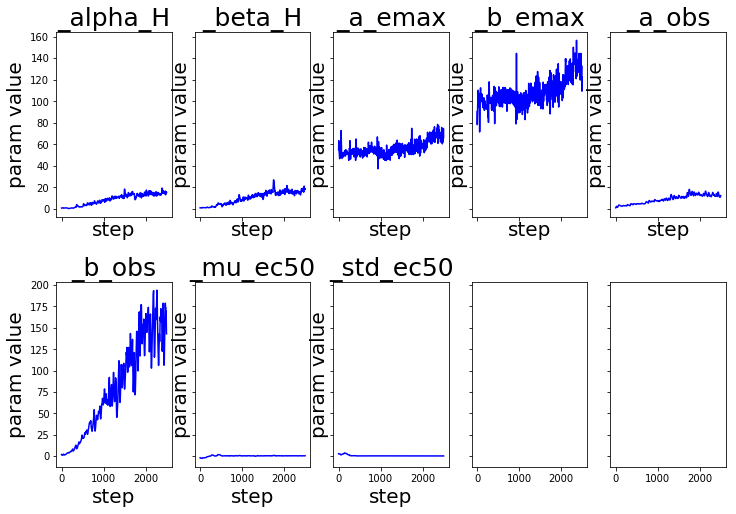

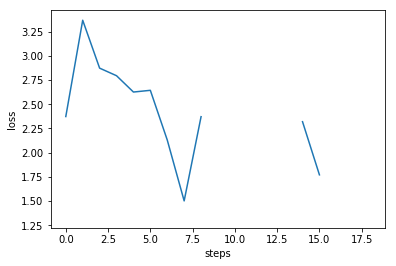

time to train 2500 iterations: 25s


In [304]:
Y = torch.tensor([1., 1., 1., 0.9, 0.7, 0.6, 0.5], dtype=torch.float)
X = torch.tensor([10./3**i for i in range(7)][::-1], dtype=torch.float).unsqueeze(-1)

adam = optim.Adam({"lr": 1e-1})

svi = SVI(model, guide, adam, loss=Trace_ELBO())

tic = time.time()
STEPS = 2500
pyro.clear_param_store() 
myplotter = plotter(['_alpha_H', '_beta_H', '_a_emax', '_b_emax', '_a_obs', '_b_obs', '_mu_ec50', '_std_ec50'], figsize=(12, 8), subplots=(2,5))
_losses = []
last=0
loss = 0
n = 100

try: 
    for j in range(STEPS):
        loss += svi.step(X, Y) 
        myplotter.record()
        if j % n == 0:
            print(f"[iteration {j}] loss: {(loss / n) :.2f} [change={(loss/n - last/n):.2f}]", end='\t\t\t\r')
            _losses.append(np.log10(loss))
            last = loss
            loss = 0
    myplotter.plot_all()
except: 
    myplotter.plot_all()
    raise
    
plt.figure()
plt.plot(_losses)
plt.xlabel('steps')
plt.ylabel('loss')
plt.show()

toc = time.time()
print(f'time to train {STEPS} iterations: {toc-tic:.2g}s')

## Plot SVI results 

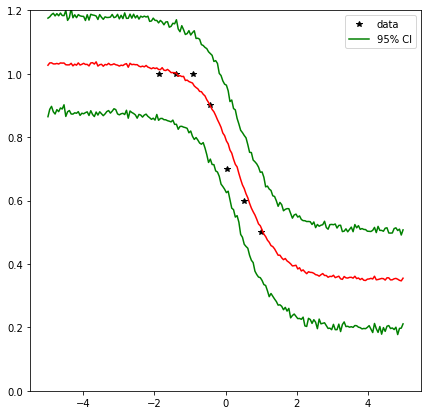

In [307]:
x_data = torch.tensor(np.logspace(-5, 5, 200)).unsqueeze(-1)

def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats


predictive = Predictive(model, guide=guide, num_samples=800,
                        return_sites=("linear.weight", "obs", "_RETURN"))

samples = predictive(x_data)
pred_summary = summary(samples)

y_mean = pred_summary['obs']['mean'].detach().numpy()
y_5 = pred_summary['obs']['5%'].detach().numpy()
y_95 = pred_summary['obs']['95%'].detach().numpy()

plt.figure(figsize=(7,7))
plt.plot(np.log10(X),Y, 'k*', label='data')
plt.plot(np.log10(x_data), y_mean, 'r-')
plt.plot(np.log10(x_data), y_5, 'g-', label='95% CI')
plt.plot(np.log10(x_data), y_95, 'g-')

plt.ylim(0,1.2)

plt.legend()
plt.show()


# Fit model with MCMC

https://forum.pyro.ai/t/need-help-with-very-simple-model/600
https://pyro.ai/examples/bayesian_regression_ii.html

In [294]:
torch.manual_seed(99999)
nuts_kernel = NUTS(model, adapt_step_size=True)
mcmc_run = MCMC(nuts_kernel, num_samples=400, warmup_steps=100, num_chains=1)
mcmc_run.run(X,Y)

Sample: 100%|██████████| 500/500 [00:49, 10.07it/s, step size=1.53e-01, acc. prob=0.979]


## visualize results

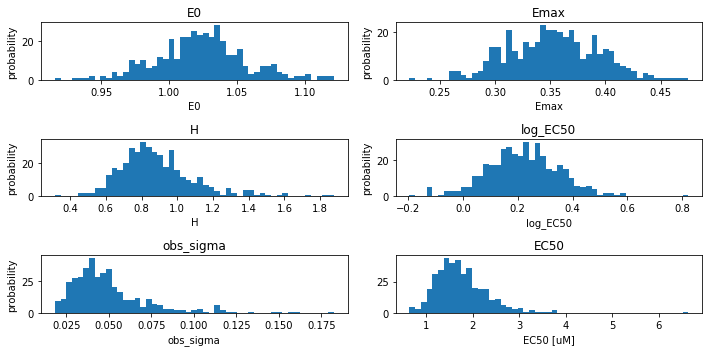

In [295]:
samples = {k: v.detach().cpu().numpy() for k, v in mcmc_run.get_samples().items()}

f, axes = plt.subplots(3,2, figsize=(10,5))

for ax, key in zip(axes.flat, samples.keys()): 
    
    ax.set_title(key)
    ax.hist(samples[key], bins=np.linspace(min(samples[key]), max(samples[key]), 50))
    ax.set_xlabel(key)
    ax.set_ylabel('probability')
    
axes.flat[-1].hist(10**samples['log_EC50'], bins=np.linspace(min(10**(samples['log_EC50'])), max(10**(samples['log_EC50'])), 50))
axes.flat[-1].set_title('EC50')
axes.flat[-1].set_xlabel('EC50 [uM]')
    
plt.tight_layout()
plt.show()

## plot fitted hill f-n

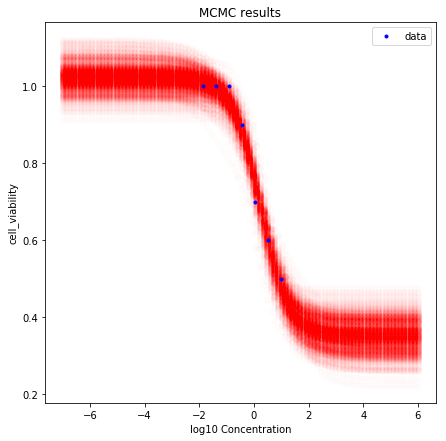

In [301]:
plt.figure(figsize=(7,7))

xx = np.logspace(-7, 6, 100)

for i,s in pd.DataFrame(samples).iterrows(): 
    yy = s.E0 + (s.Emax - s.E0)/(1+(10**s.log_EC50/xx)**s.H)
    plt.plot(np.log10(xx), yy, 'ro', alpha=0.01)
    
    
plt.plot(np.log10(X), Y, 'b.', label='data')
plt.xlabel('log10 Concentration')
plt.ylabel('cell_viability')
plt.legend()
plt.title('MCMC results')
plt.show()

# Deprecated

## EC50 example - gamma in concentration space 

In [151]:
def f(alpha_ec50=1, beta_ec50=0.5):
    f, axes = plt.subplots(1,2,figsize=(8,4))
    
    xx = np.logspace(-5, 2, 100)
    g = gamma(alpha_ec50, scale=1/beta_ec50, loc=0)
    yy = g.pdf(xx)
    
    g_samples = g.rvs(1000)
    
    axes[0].plot(xx,yy, 'r-')
    
    axes[1].plot(np.log10(xx), yy, 'b-')
    plt.tight_layout()
    plt.show()

interactive_plot = interactive(f, alpha_ec50=(1,10,1), beta_ec50=(0.01,5,0.1))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=1, description='alpha_ec50', max=10, min=1), FloatSlider(value=0.5, desc…